In [3]:
using PyPlot
include("/home/cmb/yusuket/scan/functions/calibration.jl")
include("/home/cmb/yusuket/scan/functions/spin_characterisation_w_HWP.jl")

function fillmap(resol::Resolution, pix)
    m = zeros(resol.numOfPixels)
    m[pix] .= 1
    return m
end

function get_numOfpixels_in_ring2(resol::Resolution, ith_ring::Int)
    if 0 > ith_ring 
        @error "ith_ring must be positive integer."
    end
    if ith_ring > resol.nsideTimesFour-1 
        @error "ith_ring must be smaller than 4nside-1"
    end
    nside = resol.nside
    npix = resol.numOfPixels
    n = ith_ring - 1
    a1 = 4
    d = 4
    if ith_ring < nside + 1
        start = 0.5*n*(2*a1+(n-1)*d)+1
        stop  = 0.5*ith_ring*(2*a1+(ith_ring-1)*d)
    elseif ith_ring < 3nside+1
        n_2 = ith_ring - nside
        n = nside - 1
        start = 0.5*nside*(2*a1+(nside-1)*d) + 4*(n_2-1)*nside + 1
        stop = 0.5*nside*(2*a1+(nside-1)*d) + 4*(n_2)*nside 
    else
        n_2 = 4nside-1 - ith_ring
        start = npix - 0.5*(n_2+1)*(2*a1+(n_2)*d) + 1
        stop = npix - 0.5*(n_2)*(2*a1+(n_2-1)*d)
    end 
    return Int(start), Int(stop)
end

get_numOfpixels_in_ring2 (generic function with 1 method)

In [4]:
res = Resolution(128)
a = getringinfo(res, 1)
a.firstPixIdx

1

In [5]:
idx = 600
FWHM = 17.9/60
hwprpm = 61
f_hwp = hwprpm/60
nside = 128

step = 3
alpha_plus_beta = 95
alpha = step:step:alpha_plus_beta-step
T_alpha = logspace(3.2, 7.2, 50)

FWHM = 17.9/60
hwprpm = 61
f_hwp = hwprpm/60

alpha_grid, T_prec_grid, T_spin_grid = gen_scan_parameter_space(alpha, T_alpha, FWHM, f_hwp, alpha_plus_beta)

ss = gen_ScanningStrategy()
ss.nside = nside
ss.sampling_rate = 1.0
ss.FP_theta = [0]
ss.FP_phi = [0]
ss.hwp_rpm = hwprpm
ss.alpha = 45#vec(alpha_grid)[idx]
ss.beta = alpha_plus_beta - ss.alpha
ss.spin_rpm = period2rpm(20, unit="min")
ss.prec_rpm = period2rpm(192.348, unit="min")
ss.coord = "E"
alpha_grid, T_prec_grid, T_spin_grid = 0, 0, 0;

In [6]:
division = 365
data = get_scaninfo_per_latitude(ss, division=division);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


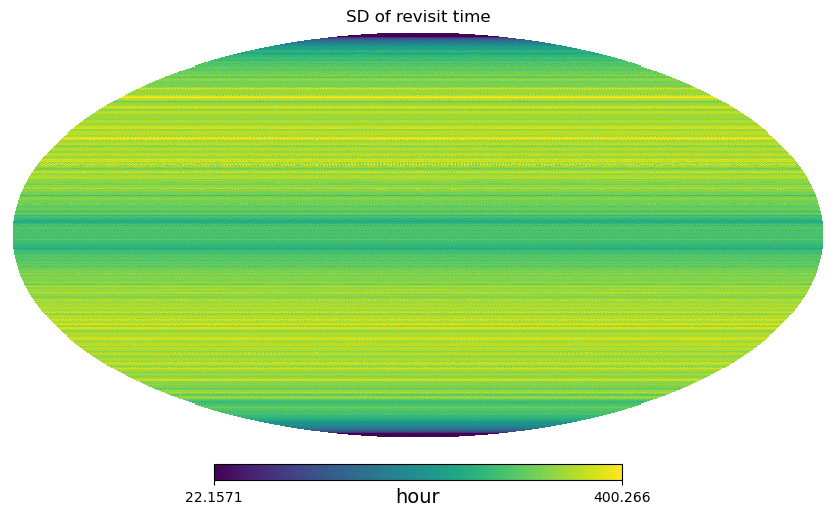

In [11]:
resol = Resolution(nside)
std_of_revisit_on_latitude = [std(diff(data.time[i])) for i in eachindex(data.latitude)]

m = zeros(resol.numOfPixels)
for i in 1:resol.nsideTimesFour-1
    start, stop = get_numOfpixels_in_ring2(resol, i)
    for j in start:stop
        m[j] = std_of_revisit_on_latitude[i] #* get_numOfpixels_in_ring(resol, i)
    end
end
hp.mollview(m/60/60, title="SD of revisit time", unit="hour")

In [8]:
mean(m)/60/60

325.19119247420616

In [9]:
result = get_revisit_info(data);
result.mean_revisit/60/60

325.1911924742062

In [10]:
#create_h5_file("./output", 1, "test2", result)

In [24]:
ss.duration = 3000
ss.nside = 64
hit = ScanningStrategy2map(ss, division=1);

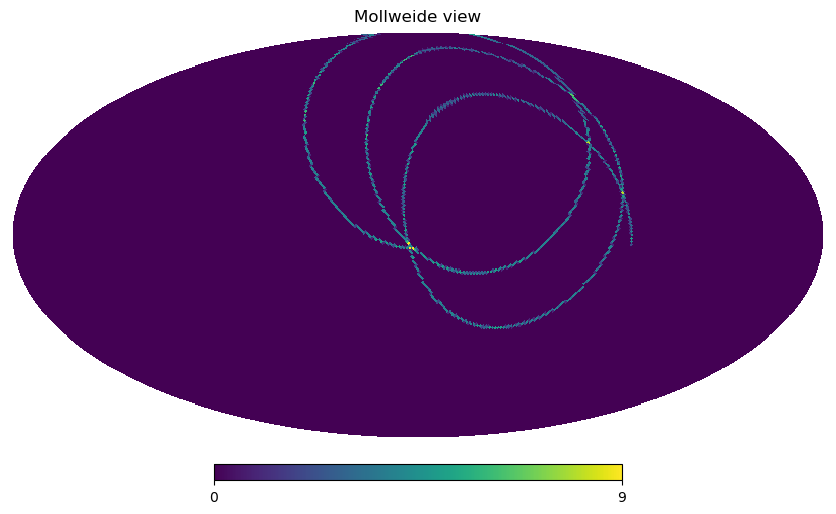

In [25]:
hp.mollview(hit[1])